# Prior distributions and their impacts

Every parameter has a distribution that represents our believes. In particular, before any new evidence brought by the likelihood of the model, we have to consider a distribution before observing the data, the prior distribution. However, it is not easy to transform prior information about a parameter into a prior distribution and bad things can happen if we do not think carefully about it. 

In [1]:
import numpy as np

from scipy.stats import loggamma

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha

## Defining prior distributions on $\alpha$

As we estabished, we want to define a jointly distribution for the Sensitivity and Specificity thorough the Bivariate Beta distribution defined [before](bivariate-beta). Then we can fix the parameter $\alpha = (\alpha_1, \dots, \alpha_4)$ or we can define a prior distribution over it. We will compare then afterwards. 

### The parameter is fixed

Suppose we have prior information about sensitivity and specificity. In general, the mean of each of them are a well known statistic. Other commom information is the stardard deviation or some credible interval. The ideia is to find the $\alpha$ parameter that generate the desired statistics. As proved [previously](choosing-alpha), we can calculate the error over specificity's variance if we fix the others, including the correlation parameter or not. There are two options we can follow, such as, minimizing a loss function or solving four equations and letting the sencond variance as a consequence. In the end, the result will be a $\hat{\alpha}$. This approximation will be the parameter of Bivariate Beta distribution. 

### The parameter has a distribution

We will start with the Gamma distribution, that is, 

$$
\alpha_i \sim Gamma(a^i, b^i), 
$$

such that $\mathbb{E}[\alpha_i] = a^i/b^i = \hat{\alpha}_i$ as explained before. The variance $\operatorname{Var}(\alpha_i) = a_i/b_i^2 = \hat{\alpha}_i/b_i$ will be compared numerically for different values of $b_i$. 

In [2]:
def moments_calculus(alpha): 
    
    tilde_alpha = alpha[0]+alpha[1]+alpha[2]+alpha[3]
    
    E_X = (alpha[0]+alpha[1])/tilde_alpha
    E_Y = (alpha[0]+alpha[2])/tilde_alpha
    
    Var_X = (1/(tilde_alpha*(tilde_alpha+1)))*E_X*(alpha[2] + alpha[3])
    Var_Y = (1/(tilde_alpha*(tilde_alpha+1)))*E_Y*(alpha[1] + alpha[3])
    
    den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2]+alpha[3]) + np.log(alpha[0]+alpha[2]) + np.log(alpha[1]+alpha[3])
    den = np.exp(-0.5*den)
    Cor_XY = (alpha[0]*alpha[3] - alpha[1]*alpha[2])*den
    
    return (E_X, E_Y, Var_X, Var_Y, Cor_XY)

As an example, consider the following chosen values. 

$$
m_1 = 0.9, m_2 = 0.85, sd_1 = 0.1, sd_2 = 0.1, \rho = -0.3,
$$

where $m_i$ and $sd_i$ are the mean and standard deviation of sensitivity ($i=1$) and specificity $(i=2)$. The correlation between them is $\rho$. 

In [3]:
m1 = 0.9
m2 = 0.85
v1 = (0.1)**2
v2 = (0.1)**2
rho = -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, x0 = [1,1,1,1])
print(solution.fun)

0.012752358816217887


/home/lucasmoschen/anaconda3/envs/tcc-emap/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The values were not so close as we wished, but we can move on from that. 

In [4]:
moments_calculus(solution.x)

(0.8369500942892211,
 0.7969037893597611,
 0.009082531015697922,
 0.010771953930520254,
 -0.22282213426429082)

And the solution:

In [5]:
print('alpha_hat: {}'.format(solution.x))

alpha_hat: [8.88977332e+00 2.84841539e+00 2.28676771e+00 1.38164290e-07]


----

In order to compare to the exact solution, we try to solve the system of
equations given by $E[X_1] = m_1, E[X_2] = m_2, Var(X_1) = v_1, $ and
$Cor(X_1,X_2) = \rho$. However, it will not end always well. For this case,
there is no solution. 

In [6]:
alpha, v2_hat, err_v2 = ParameterAlpha().solve_equations(m1,m2,v1,v2,rho)
print('moments bivariate beta: {}'.format(moments_calculus(alpha)))
print('alpha_hat: {}'.format(alpha))

Exception: This system does not have a solution since alpha_4 < 0

The loss function with this alpha is the following. 

---

The following function is used to obtain the Gamma parameters. We will have that 

$$
\mathbb{E}[\alpha_i] = \hat{\alpha_i} = \frac{a_i}{b_i} \implies a_i = b_i\alpha_i
$$

Therefore, 

$$
\operatorname{Var}(\alpha_i) = \frac{a_i}{b_i^2} = \frac{\hat{\alpha_i}}{b_i} \implies b_i = \frac{\hat{\alpha_i}}{Var(\alpha_i)}
$$

So, we will specify $\hat{\alpha}_i$ and $Var(\alpha_i)$ to obtain the parameters. Other interesting parameter is the Coefficient of variation $1/\sqrt{a_i}$. 

In [7]:
def gamma_parameters(alpha_i_mean, alpha_i_var = None, alpha_i_coef_var = None):
    
    if alpha_i_var is None:
        ai = (1/alpha_i_coef_var)**2
        bi = ai/alpha_i_mean
    else: 
        bi = alpha_i_mean/alpha_i_var
        ai = alpha_i_mean*bi
    return (ai, bi)

With that function, we will analise the following model structure: 

\begin{align}
    \alpha_i &\sim Gamma(a_i, b_i), i = 1, \dots, 4 \\
    U &\sim Dirichilet(\alpha_1, \alpha_2, \alpha_3, \alpha_4) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3 \\
    p &= \gamma_s\theta + (1 - \gamma_e)(1 - \theta), 
\end{align}

such that $\theta$ is fixed, for a while. 

*Remark: In more complex models, the parameter $p$ (with index $i$)  has more effects on the prior distribution and we will consider it posteriorly.*

## Comparing prior distributions 

After we established all the necessary steps, we can proceed the analysis of
the prior distributions. Since the dependence of $p$ on $\alpha$ is very hard
to calculate analytically, numerical simulations are required. After fixing
$\hat{\alpha}$ as explained in the previous section, the variance of the prior
distribution of $p$ must be considered. We will do it varying the coefficient
of variation, but it will be the same for each $\alpha_i$. 

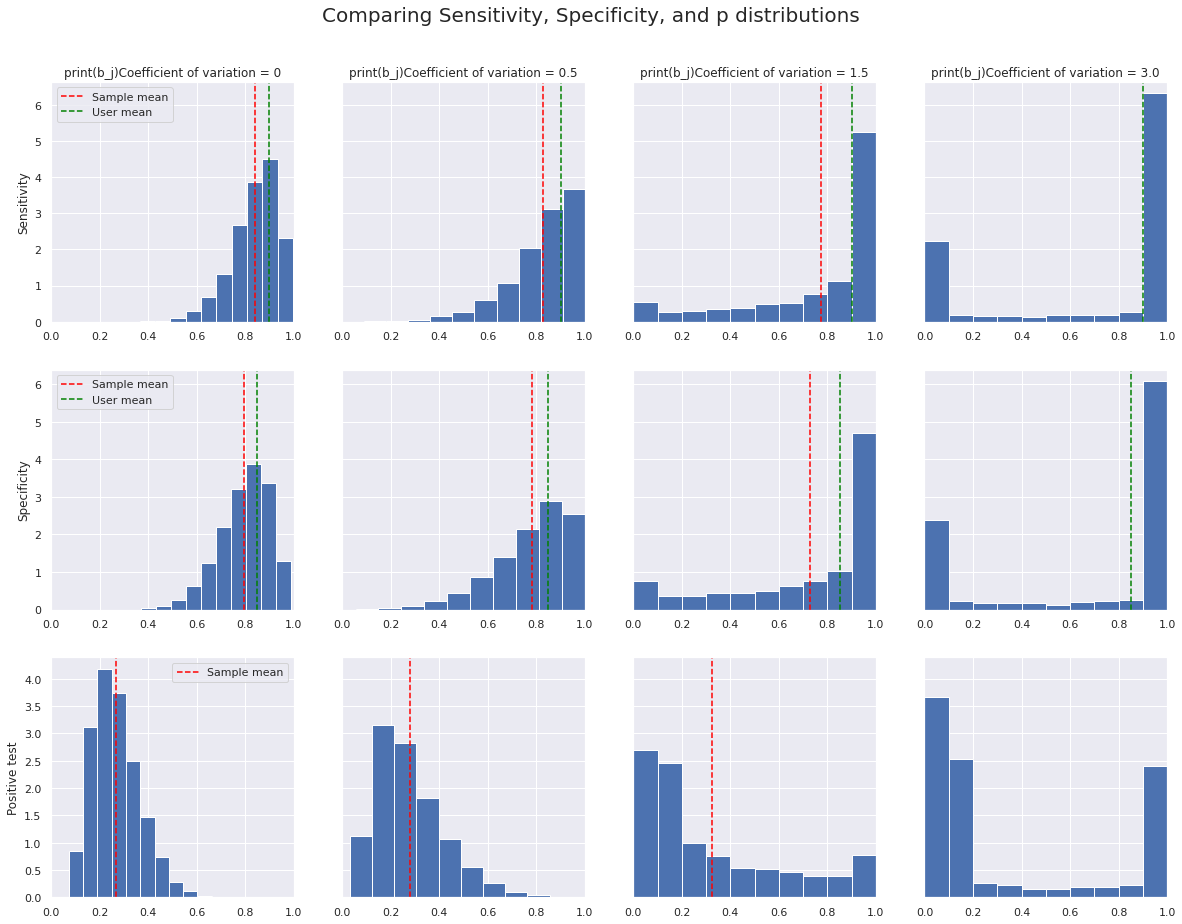

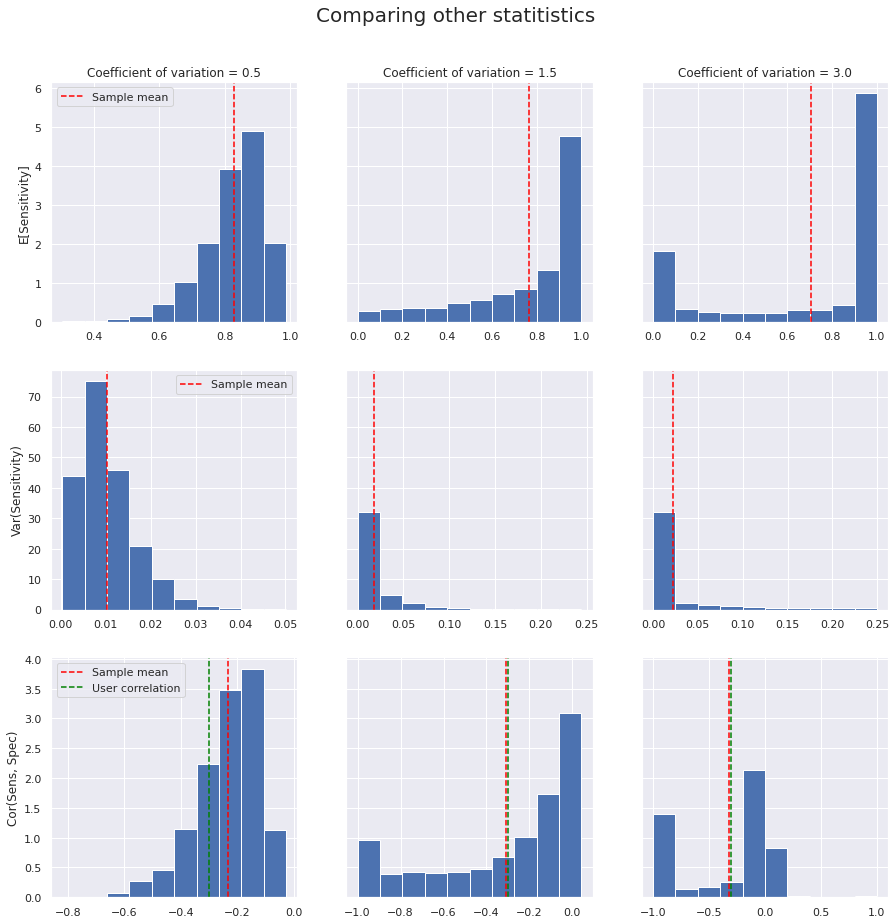

In [8]:
# Different coefficients 
# When 0, we consider dirac distribution over alpha_hat. 
coefficients_variation = [0, 0.5, 1.5, 3.0]

# Fixing theta
theta = 0.1 

# Optimizing the values of alpha
alpha_hat = solution.x

number_samples = 5000

fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (20,15), sharey = 'row')
fig.suptitle('Comparing Sensitivity, Specificity, and p distributions', fontsize = 20, y = 0.95)

fig2, ax2 = plt.subplots(nrows = 3, ncols = 3, figsize = (15,15), sharey = 'row')
fig2.suptitle('Comparing other statitistics', fontsize = 20, y = 0.95)

for i, coef in enumerate(coefficients_variation): 
    
    # Sampling alpha when it is not dirac distribution
    alpha = np.ones((number_samples,4))*alpha_hat
    if coef != 0: 
        for j, mean in enumerate(alpha_hat):
            a_j, b_j = gamma_parameters(mean, alpha_i_coef_var = coef)
            Z = loggamma(c = a_j).rvs(size = number_samples)
            alpha[:,j] = np.exp(Z)/b_j
    
    # sampling the dirichlet distribution
    U = np.array([np.random.dirichlet(alpha[s,:]) for s in range(number_samples)])
    # sensibility, sensitivity, and probability of a positive test.
    gamma_s = U[:,0] + U[:,1]
    gamma_e = U[:,0] + U[:,2]
    p = gamma_s*theta + (1 - gamma_e)*(1 - theta)

    # Plotting the first figure

    ax[0,i].hist(gamma_s, density = True)
    ax[1,i].hist(gamma_e, density = True)
    ax[2,i].hist(p, density = True)
    
    ax[0,i].axvline(gamma_s.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
    ax[1,i].axvline(gamma_e.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
    ax[2,i].axvline(p.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
    
    ax[0,i].axvline(m1, color = 'green', linestyle = '--', label = 'User mean')
    ax[1,i].axvline(m2, color = 'green', linestyle = '--', label = 'User mean')
    
    if i == 0: 
        for j in range(3):
            ax[j,i].legend()
    
    ax[0,i].set_xlim((0,1))
    ax[1,i].set_xlim((0,1))
    ax[2,i].set_xlim((0,1))
    
    ax[0,i].set_title('print(b_j)Coefficient of variation = {}'.format(coef))

    if coef != 0: 
        # Other statistics 
        E_X, _, Var_X, _, Cor_XY = moments_calculus(alpha.transpose())

        # Plotting the second figure
        ax2[0,i-1].hist(E_X, density = True)
        ax2[1,i-1].hist(Var_X, density = True)
        ax2[2,i-1].hist(Cor_XY, density = True)

        ax2[0,i-1].axvline(E_X.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
        ax2[1,i-1].axvline(Var_X.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
        ax2[2,i-1].axvline(Cor_XY.mean(), color = 'red', linestyle = '--', label = 'Sample mean')
        ax2[2,i-1].axvline(rho, color = 'green', linestyle = '--', label = 'User correlation')

        ax2[0,i-1].set_title('Coefficient of variation = {}'.format(coef))

        if i == 1: 
            for j in range(3):
                ax2[j,i-1].legend()
    
ax[0,0].set_ylabel('Sensitivity')
ax[1,0].set_ylabel('Specificity')
ax[2,0].set_ylabel('Positive test')

ax2[0,0].set_ylabel('E[Sensitivity]')
ax2[1,0].set_ylabel('Var(Sensitivity)')
ax2[2,0].set_ylabel('Cor(Sens, Spec)')

plt.show()

*Remark: Since $\hat{\alpha}_4$ is too small, the samples for $\alpha_4$ can
be really small when tha variance grows. This implies that, numerically,
Dirichlet distribution cannot sample properly.*